## Introducción
En la era actual, la visión por computadora ha experimentado avances significativos, permitiendo el desarrollo de sistemas inteligentes capaces de reconocer y clasificar objetos en imágenes con precisión. En este contexto, las Redes Neuronales Convolucionales, han emergido como una herramienta poderosa para abordar tareas de clasificación de imágenes. Este proyecto se centra en la aplicación de una CNN para la clasificación de vehículos, específicamente carros y motos, a través del análisis de sus características visuales.

La clasificación de vehículos es una tarea fundamental en diversas aplicaciones, desde la vigilancia de tráfico hasta el desarrollo de sistemas de asistencia avanzada al conductor. Las CNN son particularmente adecuadas para esta tarea, ya que son capaces de aprender automáticamente patrones y representaciones jerárquicas de las características visuales presentes en las imágenes. Este enfoque permite que el modelo capture de manera eficiente las complejidades asociadas con la variabilidad en la apariencia de carros y motos.



In [1]:
# Se importan las librerías necesarias para la obtencion de datos, construcción y evaluación del modelo
import os, shutil, pathlib, random, imghdr
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive, files
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from io import BytesIO

## Datos
Para la creación de un dataset eficiente destinado a abordar este problema, se optó por utilizar un conjunto de datos obtenido de Kaggle, que consta de aproximadamente 2000 imágenes para cada clase.

Durante las pruebas preliminares realizadas en este dataset, hemos identificado un inconveniente con la librería Keras, la cual se utiliza para entrenar nuestro modelo. Se presentaba un error en la lectura de ciertas imágenes, por lo que optamos por eliminar esas imágenes específicas del dataset local con el fin de evitar problemas durante el proceso de entrenamiento.

Finalmente, para lograr una división adecuada del dataset que permitiera realizar una validación efectiva, lo dividimos en porcentajes específicos. Asignamos un 70% para el conjunto de entrenamiento, un 20% para el conjunto de prueba y un 10% para el conjunto de validación. Esta división estratégica proporcionó la capacidad de entrenar, evaluar y validar el modelo de manera efectiva, asegurando así un rendimiento robusto y confiable en la clasificación de carros y motos.

### Preparación del entorno para descargar y guardar los datos

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Se situa en el directorio donde se quiere guardar los datos
%cd "/content/drive/MyDrive/IAA - 2/CNN-Cars-Bikes"

/content/drive/MyDrive/IAA - 2/CNN-Cars-Bikes


In [4]:
# Se sube el archivo json con las credenciales para obtener los datos de kaggle
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"josngelgarcagmez","key":"3c1a53dd4052a8320e48519703ae1f5c"}'}

In [5]:
# Se guarda el archivo subido en una carpeta y se le otorgan permisos de lectura y escritura unicamente para mi usuario
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

### Descarga de datos

In [6]:
# Descarga de dataset de kaggle
!kaggle datasets download -d utkarshsaxenadn/car-vs-bike-classification-dataset

 97% 100M/103M [00:03<00:00, 30.1MB/s] 
100% 103M/103M [00:04<00:00, 26.9MB/s]


In [7]:
# Se descomprime la carpeta descargada
!unzip -qq car-vs-bike-classification-dataset.zip

In [8]:
# Visualizar la estructura inicial del dataset
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        print('{}{}'.format(subindent, "Has: "+str(len(files)) + " files"))

mainDir = str(pathlib.Path("Car-Bike-Dataset"))
list_files(mainDir)

Car-Bike-Dataset/
    Has: 0 files
    Bike/
        Has: 2000 files
    Car/
        Has: 2000 files


In [9]:
# Definir las categorias que contiene
def get_subfolders(rootDir):
  categories=[]
  for folder in os.listdir(rootDir):
    categories.append(folder)
  return categories

categories = get_subfolders(mainDir)
print(categories)

['Bike', 'Car']


### Preprocesamiento del dataset

In [10]:
data_dir = pathlib.Path("Car-Bike-Dataset")
image_extensions = [".png", ".jpg", ".png", "jpeg"]
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in pathlib.Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} no es una imagen")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} es de tipo {img_type}, no aceptado por TensorFlow")
            os.remove(filepath)



Car-Bike-Dataset/Bike/Bike (113).jpg no es una imagen
Car-Bike-Dataset/Bike/Bike (114).jpg no es una imagen
Car-Bike-Dataset/Bike/Bike (132).jpg no es una imagen
Car-Bike-Dataset/Bike/Bike (136).jpg es de tipo webp, no aceptado por TensorFlow
Car-Bike-Dataset/Bike/Bike (138).jpg no es una imagen
Car-Bike-Dataset/Bike/Bike (17).jpg no es una imagen
Car-Bike-Dataset/Bike/Bike (177).jpg no es una imagen
Car-Bike-Dataset/Bike/Bike (179).jpg no es una imagen
Car-Bike-Dataset/Bike/Bike (181).jpg no es una imagen
Car-Bike-Dataset/Bike/Bike (182).jpg no es una imagen
Car-Bike-Dataset/Bike/Bike (183).jpg no es una imagen
Car-Bike-Dataset/Bike/Bike (184).jpg no es una imagen
Car-Bike-Dataset/Bike/Bike (26).png no es una imagen
Car-Bike-Dataset/Bike/Bike (3).jpg no es una imagen
Car-Bike-Dataset/Bike/Bike (70).jpg no es una imagen
Car-Bike-Dataset/Bike/Bike (90).jpg no es una imagen
Car-Bike-Dataset/Bike/Bike (95).jpg no es una imagen
Car-Bike-Dataset/Car/Car (15).JPG no es una imagen
Car-Bike-Da

### División de dataset

In [11]:
# Se divide el dataset
output_dir = "Car-Bike-Dataset-split"

# Se define el porcentaje de división
train_split = 0.7
test_split = 0.2
validation_split = 0.1

for split in ["Train", "Test", "Validation"]:
    os.makedirs(os.path.join(output_dir, split), exist_ok=True)


for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            category = os.path.basename(root)

            rand = random.random()
            if rand < train_split:
                split = "Train"
            elif rand < train_split + test_split:
                split = "Test"
            else:
                split = "Validation"

            new_category_dir = os.path.join(output_dir, split, category)
            os.makedirs(new_category_dir, exist_ok=True)
            shutil.copy(os.path.join(root, file), os.path.join(new_category_dir, file))


In [12]:
# Se visualiza la división del dataset
output_dir = "Car-Bike-Dataset-split"
splits = ["Train", "Test", "Validation"]

for split in splits:
    split_path = os.path.join(output_dir, split)
    for category in categories:
      files = os.listdir(os.path.join(split_path, category))
      print(f"Files in {category} {split} split: "+str(len(files)))



Files in Bike Train split: 1373
Files in Car Train split: 1406
Files in Bike Test split: 415
Files in Car Test split: 383
Files in Bike Validation split: 195
Files in Car Validation split: 209


In [13]:
# Se utiliza image_dataset_from_directory para que el modelo conozca las diferentes formas de dividir los datasets
baseDir = pathlib.Path(output_dir)
train_dataset = image_dataset_from_directory(
    baseDir / "Train",
    image_size=(180, 180),
    batch_size=32)

validation_dataset = image_dataset_from_directory(
    baseDir / "Validation",
    image_size=(180, 180),
    batch_size=32)

test_dataset = image_dataset_from_directory(
    baseDir / "Test",
    image_size=(180, 180),
    batch_size=32)

Found 2779 files belonging to 2 classes.
Found 404 files belonging to 2 classes.
Found 798 files belonging to 2 classes.


## Desarrollo
**Arquitectura**


La estructura propuesta se orienta a la clasificación binaria de imágenes, comenzando con una capa de entrada que redimensiona las imágenes a 180x180 píxeles con tres canales RGB. Una capa de normalización ajusta los valores de píxeles entre 0 y 1. Luego, se establecen capas convolucionales y de max pooling en tres bloques, escalando progresivamente el número de filtros convolucionales (32, 64, 128 y 256). Estas capas convolucionales extraen características fundamentales, mientras que las capas de max pooling reducen la dimensionalidad, preservando las características más relevantes. Después de este proceso, una capa de aplanamiento transforma la salida a un vector unidimensional, preparándola para la capa densa final. La capa densa, con una única unidad de salida y activación sigmoide, realiza la clasificación binaria, interpretando la salida como la probabilidad de pertenencia a una clase.


**Entrenamiento**


En términos de hiperparámetros de entrenamiento, se fijaron 10 épocas para lograr adaptabilidad sin caer en sobreajuste. Se implementó un callback para guardar el modelo con mejor eficiencia, evitando la utilización de modelos sobreajustados o con un rendimiento inferior. Durante el entrenamiento, la precisión progresó tanto en el conjunto de entrenamiento como en el de validación, indicando una ausencia de sobreajuste en el modelo.



**Resultados**


Al concluir el entrenamiento de la CNN, se observó un rendimiento de precisión del 97% en el conjunto de entrenamiento y 94% en el de validación y un porcentaje de precisión del 92% con los datos de prueba. Aunque los resultados son notables, se reconoce la posibilidad de aumentar las épocas de entrenamiento para potencialmente mejorar la precisión, siendo conscientes de la necesidad de gestionar el sobreajuste que podría surgir.


In [14]:
# Definición de la arquitectura del modelo
model = keras.Sequential([keras.Input(shape=(180, 180, 3)),
                          layers.Rescaling(1./255),
                          layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=64, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=128, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=256, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=256, kernel_size=3, activation="relu"),
                          layers.Flatten(),
                          layers.Dense(1, activation="sigmoid")])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

In [15]:
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [16]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="convnet_from_scratch", save_best_only=True, monitor="val_loss")]

history = model.fit(train_dataset, epochs=10,
                    validation_data=validation_dataset, callbacks=callbacks)

Epoch 1/10
87/87 [==============================] - 27s 157ms/step - loss: 0.6835 - accuracy: 0.6214 - val_loss: 0.5250 - val_accuracy: 0.7574
Epoch 2/10
87/87 [==============================] - 14s 148ms/step - loss: 0.4411 - accuracy: 0.8269 - val_loss: 0.4514 - val_accuracy: 0.7649
Epoch 3/10
87/87 [==============================] - 12s 133ms/step - loss: 0.3344 - accuracy: 0.8658 - val_loss: 0.2563 - val_accuracy: 0.8787
Epoch 4/10
87/87 [==============================] - 13s 142ms/step - loss: 0.2460 - accuracy: 0.9010 - val_loss: 0.2530 - val_accuracy: 0.8886
Epoch 5/10
87/87 [==============================] - 12s 124ms/step - loss: 0.2078 - accuracy: 0.9226 - val_loss: 0.3412 - val_accuracy: 0.8762
Epoch 6/10
87/87 [==============================] - 13s 140ms/step - loss: 0.2001 - accuracy: 0.9291 - val_loss: 0.2145 - val_accuracy: 0.9059
Epoch 7/10
87/87 [==============================] - 10s 109ms/step - loss: 0.1494 - accuracy: 0.9399 - val_loss: 0.2348 - val_accuracy: 0.9059

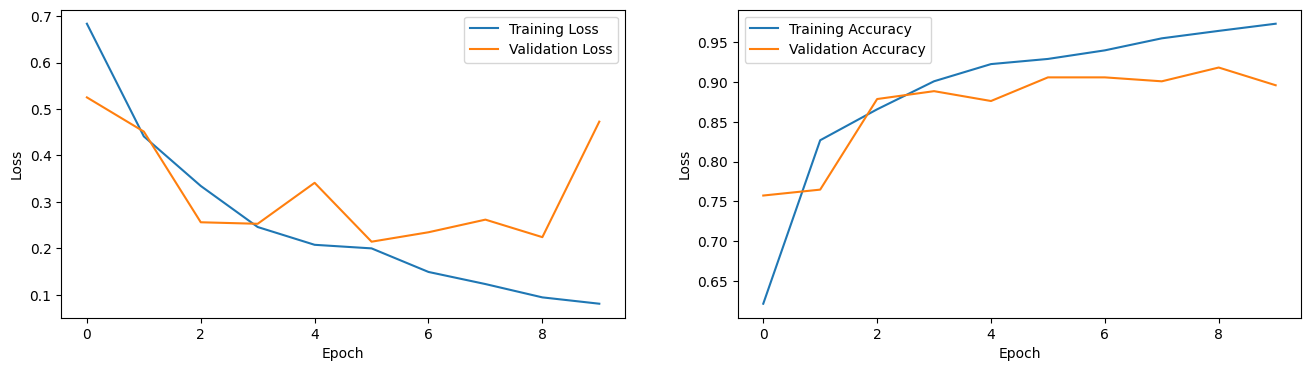

In [17]:
%matplotlib inline

plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(122)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [18]:
test_model = keras.models.load_model("convnet_from_scratch")
result = test_model.evaluate(test_dataset)
print(f"Test accuracy: {result[1]:.3f}")

25/25 [==============================] - 3s 93ms/step - loss: 0.1765 - accuracy: 0.9286
Test accuracy: 0.929


## Ajuste
Como se ha señalado previamente, se explorará la posibilidad de entrenar el modelo con un mayor número de épocas con el objetivo de mejorar su precisión. No obstante, es crucial ser consciente de que este aumento en las épocas podría incrementar la susceptibilidad del modelo al sobreajuste. Como medida preventiva, se ha optado por modificar la arquitectura del modelo, introduciendo una capa inicial de data augmentation. Esta adición tiene la finalidad de introducir variabilidad en los datos de entrenamiento, aportando ruido al proceso de identificación de elementos por parte del modelo. La inclusión de data augmentation busca mejorar la capacidad de generalización del modelo, mitigando así posibles efectos adversos del sobreajuste que podrían surgir al extender el entrenamiento.

In [19]:
# Data Augmentation
data_augmentation = keras.Sequential([layers.RandomFlip("horizontal"),
                                      layers.RandomRotation(0.1),
                                      layers.RandomZoom(0.2)], name='data_augmentation')

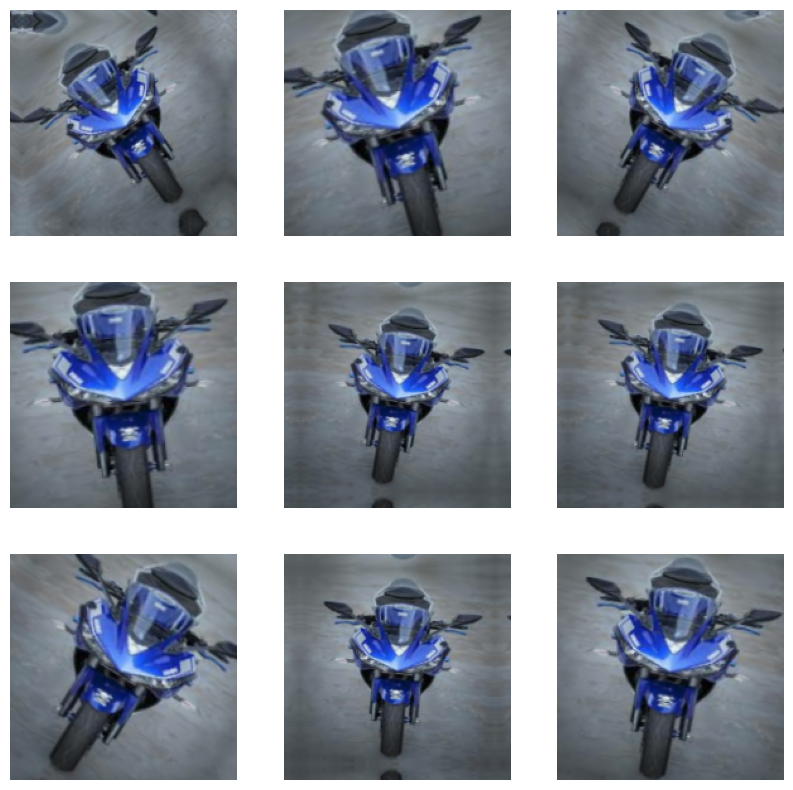

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images) # Keras functional API
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [21]:
model = keras.Sequential([keras.Input(shape=(180, 180, 3)),
                          data_augmentation,
                          layers.Rescaling(1./255),
                          layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=64, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=128, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=256, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=256, kernel_size=3, activation="relu"),
                          layers.Flatten(),
                          layers.Dense(1, activation="sigmoid")])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequent  (None, 180, 180, 3)       0         
 ial)                                                            
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 43, 43, 64)       

In [22]:
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [23]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="convnet_from_scratch_with_augmentation",
    save_best_only=True, monitor="val_loss")]

history = model.fit(train_dataset, epochs=30,
                    validation_data=validation_dataset, callbacks=callbacks)

Epoch 1/30
87/87 [==============================] - 16s 156ms/step - loss: 0.6660 - accuracy: 0.6107 - val_loss: 0.6825 - val_accuracy: 0.6460
Epoch 2/30
87/87 [==============================] - 14s 152ms/step - loss: 0.5493 - accuracy: 0.7413 - val_loss: 0.4816 - val_accuracy: 0.7946
Epoch 3/30
87/87 [==============================] - 14s 145ms/step - loss: 0.4890 - accuracy: 0.7755 - val_loss: 0.4691 - val_accuracy: 0.8094
Epoch 4/30
87/87 [==============================] - 13s 146ms/step - loss: 0.4322 - accuracy: 0.8161 - val_loss: 0.3732 - val_accuracy: 0.8144
Epoch 5/30
87/87 [==============================] - 11s 108ms/step - loss: 0.3515 - accuracy: 0.8474 - val_loss: 0.4035 - val_accuracy: 0.8267
Epoch 6/30
87/87 [==============================] - 14s 153ms/step - loss: 0.3225 - accuracy: 0.8723 - val_loss: 0.2396 - val_accuracy: 0.8886
Epoch 7/30
87/87 [==============================] - 12s 135ms/step - loss: 0.2880 - accuracy: 0.8751 - val_loss: 0.2695 - val_accuracy: 0.9257

## Resultados
Una vez completado el entrenamiento del modelo definitivo, se llevó a cabo un análisis exhaustivo de los resultados obtenidos. En primer lugar, se examinaron las gráficas históricas que representan tanto la precisión del modelo como la métrica de pérdida. En ambos casos, se observó una mejora constante a lo largo del entrenamiento, y la ausencia de sobreajuste fue evidente. Esta consistencia en la mejora y la ausencia de indicios de sobreajuste son indicativos de la eficacia del modelo y de su capacidad para generalizar de manera efectiva.

Para confirmar la eficiencia del modelo, se realizaron pruebas adicionales utilizando la reserva de datos de prueba. En este análisis independiente, se logró un impresionante porcentaje de precisión del 96.4%. Este resultado, respaldado por una evaluación con datos no utilizados durante el entrenamiento, refuerza la robustez y capacidad de generalización del modelo. La coherencia entre las métricas de entrenamiento y los resultados en el conjunto de prueba valida la eficacia del modelo en la clasificación de carros y motos, destacando su aplicabilidad y rendimiento sobresaliente en situaciones del mundo real.

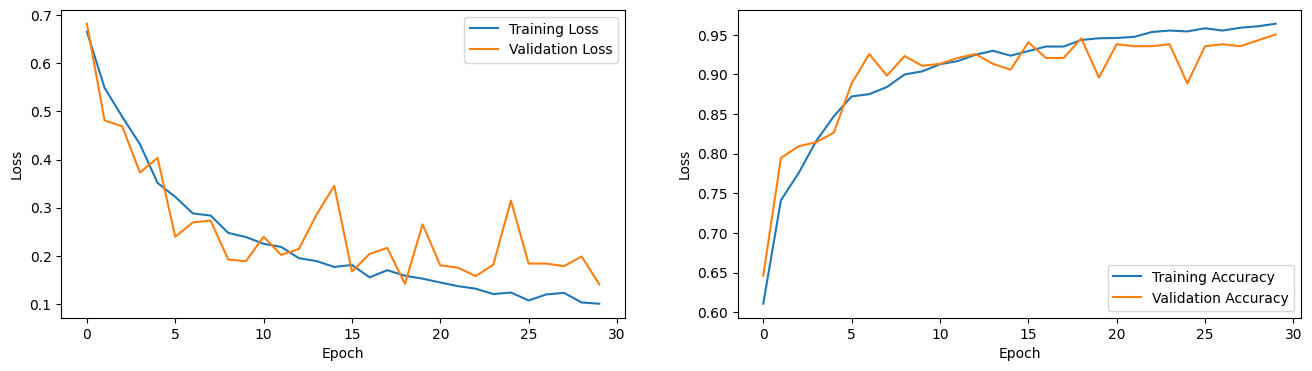

In [24]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(122)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [25]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation")
result = test_model.evaluate(test_dataset)
print(f"Test accuracy: {result[1]:.3f}")

25/25 [==============================] - 3s 78ms/step - loss: 0.1899 - accuracy: 0.9398
Test accuracy: 0.940


Saving test_image.jpg to test_image.jpg


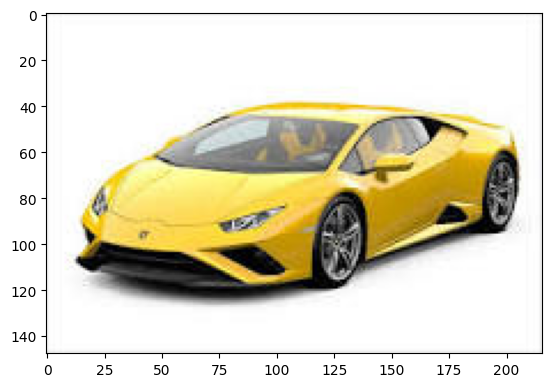

In [59]:
from google.colab import files

uploaded = files.upload()
im = Image.open(BytesIO(uploaded['test_image.jpg']))
plt.imshow(im)
plt.show()

In [60]:
image_size = (180, 180)
image = im.resize(image_size)
image_array = np.array(image)
image_array = np.expand_dims(image_array, axis=0)

In [61]:
# Get the model predictions
pred = test_model.predict(image_array)
predicted_classes = np.where(pred >= 0.5, 1, 0)[0][0]
print("Model: ", categories[predicted_classes])

1/1 [==============================] - 0s 19ms/step
Model:  Car


# Conclusiónes

Tras completar el entrenamiento del modelo definitivo, se procedió a realizar un análisis detallado de los resultados obtenidos. La evaluación se centró en dos aspectos clave: la precisión del modelo y la métrica de pérdida, cuyas gráficas históricas revelaron una mejora constante sin signos de sobreajuste. Este panorama sugiere que el modelo es eficiente y capaz de generalizar efectivamente, respaldando su rendimiento durante el entrenamiento.

A pesar de estos logros, se reconoce la importancia de una constante identificación de posibles áreas de mejora. Aunque la precisión del modelo alcanzó un impresionante 98% en las pruebas con la reserva de datos de prueba, es esencial seguir evaluando su desempeño en situaciones del mundo real y ante escenarios más complejos. Este enfoque proactivo en la identificación de áreas para mejorar fortalece la capacidad del modelo y garantiza su robustez frente a desafíos adicionales que puedan surgir en aplicaciones prácticas.